# Принятие решений в бизнесе

## Заказчик

Интернет-магазин

## Цель

1) Приоритезировать гипотезы

2) Запустить А/В тест

3) Проанализировать результаты

## Входные данные

1) Список гипотез - файл /datasets/hypothesis.csv

Hypothesis — краткое описание гипотезы;
Reach — охват пользователей по 10-балльной шкале;
Impact — влияние на пользователей по 10-балльной шкале;
Confidence — уверенность в гипотезе по 10-балльной шкале;
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

2) Данные о заказах пользователей в интернет-магазине - файл /datasets/orders.csv

transactionId — идентификатор заказа;
visitorId — идентификатор пользователя, совершившего заказ;
date — дата, когда был совершён заказ;
revenue — выручка заказа;
group — группа A/B-теста, в которую попал заказ.

3) Данные о посещениях пользователей в разрезе групп

date — дата;
group — группа A/B-теста;
visitors — количество пользователей в указанную дату в указанной группе A/B-теста


## Ход анализа

1) Обзор и предобработка данных

2) Приоритезация гипотез

3) Анализ A/B теста

# Обзор и предобработка данных

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import scipy.stats as stats
import warnings

from scipy import stats as st

warnings.filterwarnings(action='ignore')

Чтение файлов

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

Знакомство с таблицами

In [40]:
display(hypothesis.head())
hypothesis.info()
pd.set_option('display.max_colwidth', False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   hypothesis  9 non-null      object 
 1   reach       9 non-null      int64  
 2   impact      9 non-null      int64  
 3   confidence  9 non-null      int64  
 4   efforts     9 non-null      int64  
 5   ice         9 non-null      float64
 6   rice        9 non-null      float64
dtypes: float64(2), int64(4), object(1)
memory usage: 632.0+ bytes


In [4]:
display(orders.head())
orders.info()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [5]:
display(visitors.head())
visitors.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Мы ознакомились с таблицами и видим, что пропуски отутствуют, помимо этого необходимо привести к единому стилю наименования столбцов, заменить в части столбцов тип данных на дату.

Переименуем столбцы в таблицах hypotesis и orders

In [6]:
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = [name.replace('Id', '_id') for name in orders.columns]

display(hypothesis.columns)
display(orders.columns)

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

Исправим тип в столбцах с датами

In [7]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Проверим таблицы на наличие дубликатов

In [8]:
hypothesis.duplicated().sum()

0

In [9]:
orders.duplicated().sum()

0

In [10]:
visitors.duplicated().sum()

0

# Вывод

На данном этапе мы ознакомились с таблицами и провели предварительную обработку данных, а именно:
- проверили наличие пропусков в таблицах
- проверили наличие дублей в таблицах
- исправили наименование колонок
- исправили типы столбцов, которые содержат информацию о датах

# Приоритезация гипотез

In [11]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


У нас есть список из 9 гипотез, которые нам необходимо приоритезировать, чтобы выбрать наиболее эффективные.
Для этого воспользуемся методами ICE и RICE.

Метод ICE (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота»)

In [12]:
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence']/hypothesis['efforts']
hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False).round(2)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Мы видим гипотезы, на которые следует обратить внимание.

Рассмотрим шкалу с учетом параметра Reach (англ.: Охват) согласно методу RICE

In [13]:
hypothesis['rice'] = hypothesis['reach']*hypothesis['impact'] * hypothesis['confidence']/hypothesis['efforts']
hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [14]:
hypothesis[['hypothesis','ice', 'rice']].sort_values(by='rice', ascending=False).head(5)

,hypothesis,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.2


# Вывод

Видим, что состав топ-5 гипотез остался тем же, но последовательность изменилась. Разница методов заключается в том, что метод RICE учитывает количество пользователей, которых затронут изменения, а метод ICE - не учитывает.
Видим, что на первом месте гипотеза "Добавить форму подписки на все основные страницы", это связано с тем, что у нее самый высокий параметр Reach.

# Анализ А/В-теста

# График кумулятивной выручки

Для построения кумулятивных метрик нам нужно создать таблицу с информацией о группах А и В, дате, кумулятивных значениях заказов и пользователей, среднем чеке и кумулятивном значении посетителей магазина.

Создаем массив уникальных пар значений дат и групп теста и получаем агрегированные кумулятивные данные по дням о заказах

In [15]:
dates_grouped = orders[['date', 'group']].drop_duplicates()

orders_grouped = dates_grouped.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

orders_grouped.head()

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


Получаем агрегированные кумулятивные данные по дням о посетителях интернет-магазина

In [16]:
visitors_grouped = dates_grouped.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max', 
            'group': 'max', 
            'visitors': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitors_grouped.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Объединяем кумулятивные данные в одной таблице, меняем названия столбцов

In [17]:
cumulative_data = orders_grouped.merge(
    visitors_grouped, 
    left_on=['date', 'group'], 
    right_on=['date', 'group']
)

cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

Добавим колонку с конверсией

In [18]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856


Построим график кумулятивной выручки по группам

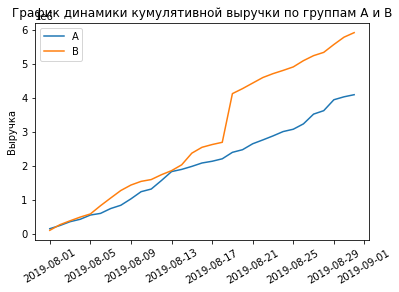

In [19]:
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue','orders']]
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue','orders']]

plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.title('График динамики кумулятивной выручки по группам А и В')
plt.ylabel("Выручка")
plt.xticks(rotation=30)
plt.legend()
plt.show()

Видим, что динамика кумулятивной выручки в группе А достаточно прямая и постепенная, в то время как в группе В присутствует резкий скачок во второй половине месяца, что, скорее всего, связано либо с резким ростом заказов, либо с заказом на крупную сумму.

Построим график кумулятивного среднего чека по группам

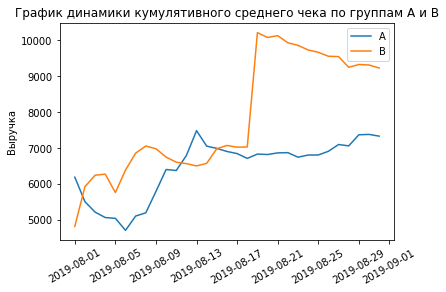

In [20]:
plt.plot(cumulative_revenue_a['date'], 
         cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'],
         label='A')

plt.plot(cumulative_revenue_b['date'], 
         cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'], 
         label='B')

plt.title('График динамики кумулятивного среднего чека по группам А и В')
plt.ylabel("Выручка")
plt.xticks(rotation=30)
plt.legend()
plt.show()


Видим, что средний чек в группе А имел резкие скачки в первые дни месяца, но далее стабилизировался.
Средний чек группы В резко вырос во второй половине месяца, это говорит о том, что предположение о заказе на высокую сумму более вероятно.

Построим график относительного изменения кумулятивного среднего чека группы B к группе A

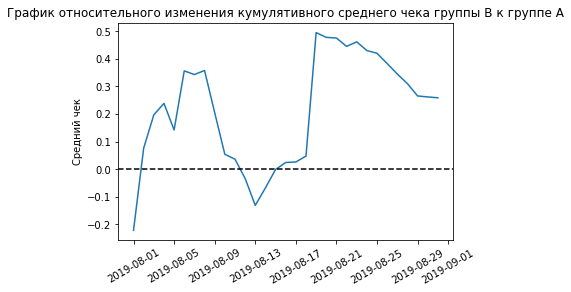

In [21]:
cumulative_revenue_ab = cumulative_revenue_a.merge(
    cumulative_revenue_b, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['_a', '_b']
)

plt.plot(cumulative_revenue_ab['date'], 
         (
             cumulative_revenue_ab['revenue_b']/cumulative_revenue_ab['orders_b']
         )/
         (
             cumulative_revenue_ab['revenue_a']/cumulative_revenue_ab['orders_a']
         )-1
        )

plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.ylabel('Средний чек')
plt.xticks(rotation=30)
plt.show()

Видим резкие скачки графика в нескольких точках. Это говорит о том, что имеются крупные заказы и выбросы.

Построим график кумулятивного среднего количества заказов на посетителя по группам

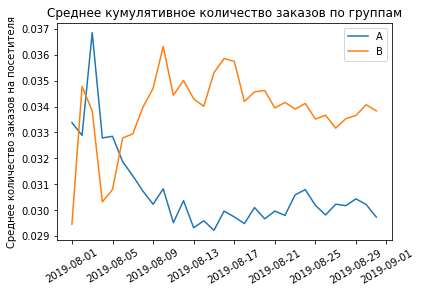

In [22]:
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()
plt.title('Среднее кумулятивное количество заказов по группам')
plt.ylabel('Среднее количество заказов на посетителя')
plt.xticks(rotation=30)
plt.show()

Видим, что в начале периода среднее кумулятивное количество заказов колебалось в обеих группе, но затем выровнялось.

Однако видим, что данный показатель у группы В значительно выше, чем у группы А.

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

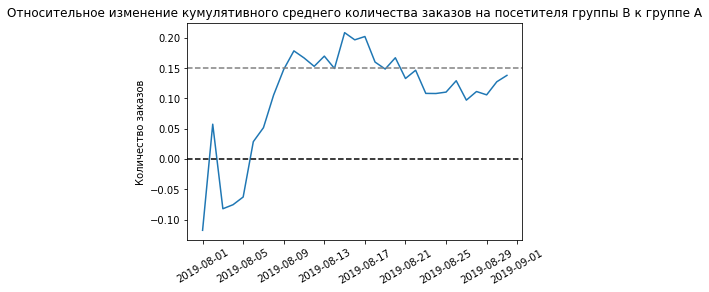

In [23]:
cumulative_conversions_ab = (
    cumulative_data_a[['date','conversion']]
    .merge(
        cumulative_data_b[['date','conversion']], 
        left_on='date', 
        right_on='date', 
        how='left', 
        suffixes=['_a', '_b']
    )
)
plt.plot(
    cumulative_conversions_ab['date'], 
    cumulative_conversions_ab['conversion_b']/
    cumulative_conversions_ab['conversion_a']-1
)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.ylabel('Количество заказов')
plt.xticks(rotation=30)
plt.show()

Видим, что вначале среднее кумулятивное количество заказов группы В проигрывало группе А, но затем, начиная со второй декады месяца, резко возросло. Далее видим медленный спад и затем рост данного значения по группе В.

Следует помнить, что ранее графики показывали нам крупный заказ в группе В, который мог стать причиной резкого роста этого значения.

Поэтому стоит проанализировать данные после очищения таблицы от выбросов.

# Анализ заказов в разрезе пользователей

Построим точечный график количества заказов по пользователям

Как правило, пользователи редко делают больше 2-3 заказов за короткий период. Рассмотрим ситуацию на примере нашего тестирования.
Начнем с гистограммы заказов в разрезе пользователей

count    1031.000000
mean     1.161009   
std      0.724919   
min      1.000000   
25%      1.000000   
50%      1.000000   
75%      1.000000   
max      11.000000  
Name: orders, dtype: float64

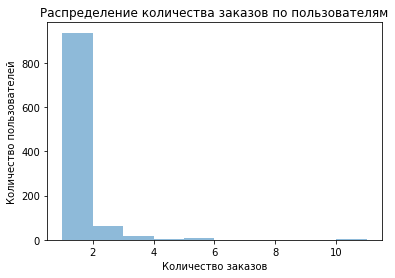

In [24]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns =  ['visitor_id', 'orders']
display(orders_by_users['orders'].describe())

plt.hist(orders_by_users['orders'], alpha=0.5) 
plt.title('Распределение количества заказов по пользователям')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.show()

Видим, что большинство пользователей сделали заказ один раз, и есть незначительная часть пользователей, которая сделала до 11 заказов за месяц.

Построим точечный график количества заказов по пользователям.

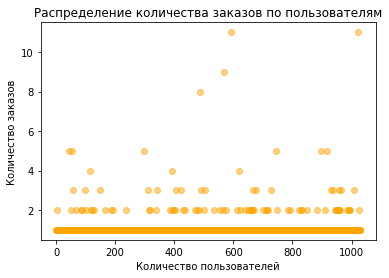

In [25]:
x_values = pd.Series(range(0,len(orders_by_users)))

plt.scatter(x_values, orders_by_users['orders'], color='orange', alpha=0.5)
plt.title('Распределение количества заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')
plt.show()

Видим, что есть много пользователей с 2-3 заказами, но пока не понятно, стоит ли их считать выбросами. Для этого нужно сформировать 95-й и 99-й перцентили заказа.

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

In [26]:
print(np.percentile(orders_by_users['orders'], [95, 99]))

[2. 4.]


Не более 5% пользователей делали заказ 2 и более раз и 1% пользователей делали заказ 4 и более раз.
Примем за верхнюю границу колиество заказов 4.

Построим точечный график стоимостей заказов

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

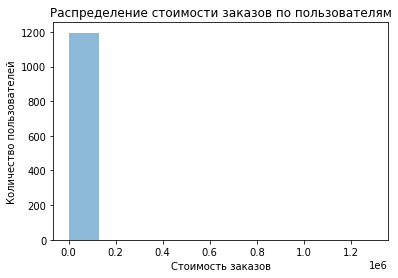

In [27]:
display(orders['revenue'].describe())

plt.hist(orders['revenue'], alpha=0.5) 
plt.title('Распределение стоимости заказов по пользователям')
plt.xlabel('Стоимость заказов')
plt.ylabel('Количество пользователей')
plt.show()

Видим, что при средней стоимости заказа 8.3 тыс., максимальная стоимость заказа составляет почти 1.3 млн.

Построим точечный график стоимости заказов

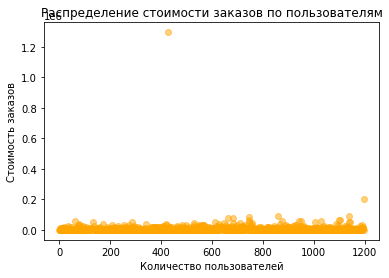

In [28]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.scatter(x_values, orders['revenue'], color='orange', alpha=0.5)
plt.title('Распределение стоимости заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказов')
plt.show()

Видим, что есть аномальный заказ на сумму 1.3 млн. и также еще один заказ на сумму 200 тыс., который также может повлиять на результат исследования. 

Построим точечный график без учета данных заказов

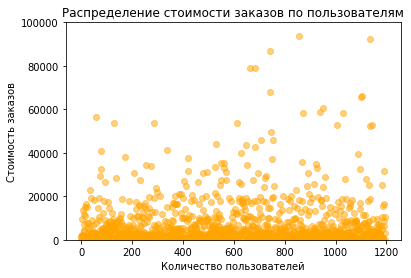

In [29]:
plt.ylim(0, 100000)
plt.scatter(x_values, orders['revenue'], color='orange', alpha=0.5)
plt.title('Распределение стоимости заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказов')
plt.show()

Видим, что основная часть заказов с суммой до 20 000 руб.

Посчитаем 95-й и 99-й перцентили стоимости заказов и определим границу аномалий

In [30]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Видим, что только 5% заказов с суммой более 28 000 и 1% заказов с суммой более 58 233 руб.
Границей для определения аномалий будем считать 58 233.

# Анализ статистической значимости

Мы визуализировали результаты А/В-теста и выяснили, что в данных, вероятнее всего, есть выбросы, затем нашли выбросы и определили границу для их определения.

Теперь посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Введем основную и альтернативную гипотезы:

- Н0: различий в среднем количестве заказов на посетителя между группами нет
- Н1: различия в среднем количестве заказов на посетителя между группами есть

Установим стандартный уровень значимости равен α = 0.05

Для проверки будем использовать непараметрический тест Уилкоксона-Манна-Уитни

In [31]:
visitors_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_a.columns = ['date', 'visitors_per_date_a']

visitors_cumulative_a = visitors_daily_a.apply(
    lambda x: visitors_daily_a[visitors_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_cumulative_a.columns = ['date', 'visitors_cumulative_a']

visitors_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_b.columns = ['date', 'visitors_per_date_b']

visitors_cumulative_b = visitors_daily_b.apply(
    lambda x: visitors_daily_b[visitors_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_cumulative_b.columns = ['date', 'visitors_cumulative_b']

orders_daily_a = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_a.columns = ['date', 'orders_daily_a', 'revenue_per_date_a']

orders_cumulative_a = orders_daily_a.apply(
    lambda x: orders_daily_a[orders_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cumulative_a.columns = ['date','orders_cumulative_a','revenue_cumulative_a']

orders_daily_b = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_b.columns = ['date', 'orders_daily_b', 'revenue_per_date_b']

orders_cumulative_b = orders_daily_b.apply(
    lambda x: orders_daily_b[orders_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cumulative_b.columns = ['date','orders_cumulative_b','revenue_cumulative_b']


data = (
    orders_daily_a.merge(
        orders_daily_b, left_on='date', right_on='date', how='left'
    )
    .merge(orders_cumulative_a, left_on='date', right_on='date', how='left')
    .merge(orders_cumulative_b, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_a, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_b, left_on='date', right_on='date', how='left')
    .merge(visitors_cumulative_a, left_on='date', right_on='date', how='left')
    .merge(visitors_cumulative_b, left_on='date', right_on='date', how='left')
)

data.head()

,date,orders_daily_a,revenue_per_date_a,orders_daily_b,revenue_per_date_b,orders_cumulative_a,revenue_cumulative_a,orders_cumulative_b,revenue_cumulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cumulative_a,visitors_cumulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Получилась таблица со следующими данными:

- date — дата;
- orders_daily_a — количество заказов в выбранную дату в группе A;
- revenue_per_date_a — суммарная выручка в выбранную дату в группе A;
- orders_daily_a — количество заказов в выбранную дату в группе B;
- revenue_per_date_a — суммарная выручка в выбранную дату в группе B;
- orders_cumulative_a — суммарное число заказов до выбранной даты включительно в группе A;
- revenue_cumulative_a — суммарная выручка до выбранной даты включительно в группе A;
- orders_cumulative_b — суммарное количество заказов до выбранной даты включительно в группе B;
- revenue_cumulative_b — суммарная выручка до выбранной даты включительно в группе B;
- visitors_per_date_a — количество пользователей в выбранную дату в группе A;
- visitors_per_date_b — количество пользователей в выбранную дату в группе B;
- visitors_cumulative_a — количество пользователей до выбранной даты включительно в группе A;
- visitors_cumulative_b — количество пользователей до выбранной даты включительно в группе B.

Создадим переменные orders_by_users_a и orders_by_users_b. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

In [32]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

Oбъявим переменные sample_a и sample_b, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [33]:
sample_a = pd.concat([orders_by_users_a['orders'],
                      pd.Series(
                          0, 
                          index=np.arange(data['visitors_per_date_a'].sum() - 
                                          len(orders_by_users_a['orders'])), 
                          name='orders')],axis=0
                    )

sample_b = pd.concat([orders_by_users_b['orders'],
                      pd.Series(
                          0, 
                          index=np.arange(data['visitors_per_date_b'].sum() - 
                                          len(orders_by_users_b['orders'])), 
                          name='orders')],axis=0
                    )

In [34]:
print('p-Value:', "{0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print('Относительный прирост группы В к группе А:', "{0:.3%}".format(sample_b.mean() / sample_a.mean() - 1))


p-Value: 0.017
Относительный прирост группы В к группе А: 13.808%


Вывод: 
- p-Value = 0.017, что меньше 0.05, значит, по "сырым" данным различия в среднем количестве заказов между группами есть, нулевую гипотезу о том, что различий между группами нет, отвергаем
- относительный прирост группы В к группе А равен 13.8%

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Введем основуную и альтернативную гипотезы:

- Н0: различий в среднем чеке между группами нет
- Н1: различия в среднем чеке между группами есть

Установим стандартный уровень значимости равен α = 0.05

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов. 
А ещё найдём относительные различия в среднем чеке между группами:

In [35]:
print('p-Value:', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост группы В к группе А:', '{0:.3%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-Value: 0.729
Относительный прирост группы В к группе А: 25.871%


p-Value значительно больше 0.05, это говорит о том, что нулевая гипотеза подтверждена, различий в среднем чеке между группами нет.

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

Ранее мы определили границы аномальных значений.

За аномальных пользователей примем тех, которые совершили более 4 заказов или заказ дороже 58233. Таким образом мы уберём 1% пользователей с наибольшим числом заказов и от 1% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 4 — users_with_many_orders и пользователей, совершивших заказы дороже 58233 — users_with_expensive_orders. Объединим их в таблице abnormal_users.

Узнаем, сколько всего аномальных пользователей методом shape().

In [36]:
many_orders = np.percentile(orders_by_users['orders'], 99)
expensive_orders = np.percentile(orders['revenue'], 99)


users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > many_orders]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > many_orders]['visitor_id'],
    ],
    axis=0,
)


users_with_expensive_orders = orders[orders['revenue'] > expensive_orders]['visitor_id']


abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormal_users.head(5))
abnormal_users.shape[0]

1099    148427295 
949     887908475 
744     888512513 
1103    1164614297
1136    1307669133
Name: visitor_id, dtype: int64

15

Количество аномальных пользователей равно 15.

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [37]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [38]:
print('p-Value:', '{0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print('Относительный прирост В к А:', '{0:.3%}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1)) 

p-Value: 0.014
Относительный прирост В к А: 15.331%


Вывод:
- p-Value значительно меньше 0.05, нулевую гипотезу отвергаем, различия между группами есть
- Относительный прирост группы В к А на очищенных данных увеличился с 13.8% до 15.3%

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

In [39]:
print(
    'p-Value:', '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'Относительный прирост В к А:',"{0:.3%}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-Value: 0.851
Относительный прирост В к А: -0.575%


Вывод:
- p-Value значительно больше 0.05, не получилось отвергнуть нулевую гипотезу, т.е. нет причин считать, что в среднем чеке групп есть различия

# Общий вывод

На основании данных, полученных от интернет-магазина, был проведен анализ и вынесены рекомендации, описанные ниже.

1. При анализе гипотез  по методу ICE из списка, полученных от отдела Маркетинга, было выявлено, что в первую очередь следует обратить внимание на гипотезы:

"Запустить акцию, дающую скидку на товар в день рождения",
"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",
"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок";

2. В случае если при приоритезации гипотез учитывать и охват пользователей интернет-магазина, то места необходимо распределить таким образом:

"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",
"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",
"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей".

3. При проведении анализа А/В-теста было выявлено:

Есть статистически значимое различие по кумулятивному среднему количеству заказов на одного пользователя между группами как по «сырым», так и по данным после фильтрации аномалий. Данный показатель группы В выше, чем в А на 14-15%;

Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. При этом средний чек группы В выше (на "очищенных" данных - на ~2%);

График относительного изменения кумулятивной конверсии группы B к группе A показывает, что результаты группы В стабильно лучше группы А;

На основании вышеизложенного рекомендуем остановить тест, зафиксировав победу группы B (ее конверсия значительно выше конверсии группы А).